<a href="https://colab.research.google.com/github/kiranbodipati/MusicMoods/blob/master/MusicMoods_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MusicMoods**
By Varun Srikant Iyengar, Kiran Bodipati and Abhishek Vaidyanathan

## **Introduction and Imports**

***Introduction***

MusicMoods is **a music playlist recommendation system** that goes beyond the limits of genres and tags, and recommends you a great, smooth-transitioning playlist based not just on the usual features, but also on the **sentiment behind the lyrics** of a song.

***Brief Description***

For builiding the model, we used a dataset that contained data of over 300,000 songs scrapped from various sources on the internet which was found on Kaggle


> https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics/data

On this data, we performed some Natural Language Processing techniques like sentiment analysis. We then built a recommendation system by creating an algorithm that combined the benefits of both Euclidean distances and Cosine Similarity. Finally, we created visualizations to observe our models

The detailed explanation on how we went about the model has been provided below in the form of text boxes and comments 

In [0]:
#necessary imports

#basic Python Data science modules  needed for extracting, storing, and visualizing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
%matplotlib inline

#Packages needed for natural language processing and sentiment analysis of data
from gensim.summarization import keywords
import spacy
import wordcloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
from spacy.lang.en import English
nlp = English()
nlp.max_length = 10000000
from textblob import TextBlob
import re

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#modules needed for building the recommendation system and visualising it:
import sklearn.metrics.pairwise as pw
import scipy.spatial.distance as scpy
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder
from matplotlib import animation

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
#No need to run this if you're running the code locally, this is to run the notebook through colab and drive only.
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


## **Exploratory Analysis, Visualization and Cleaning of Dataset**
No need to re-run these cells, just import the cleaned and modified sentiData.csv later

In [0]:
#uncomment the following lines as required
origDataset = pd.read_csv('/gdrive/My Drive/lyrics.csv')  # when accessing through drive
#origDataset = pd.read_csv('lyrics.csv')  # accessing locally

In [0]:
origDataset.head()

index  ...                                             lyrics
0      0  ...  Oh baby, how you doing?\nYou know I'm gonna cu...
1      1  ...  playin' everything so easy,\nit's like you see...
2      2  ...  If you search\nFor tenderness\nIt isn't hard t...
3      3  ...  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...
4      4  ...  Party the people, the people the party it's po...

[5 rows x 6 columns]

In [0]:
origDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   362237 non-null  int64 
 1   song    362235 non-null  object
 2   year    362237 non-null  int64 
 3   artist  362237 non-null  object
 4   genre   362237 non-null  object
 5   lyrics  266557 non-null  object
dtypes: int64(2), object(4)
memory usage: 16.6+ MB


### **Cleaning the data**
Clearly, the lyrics of ~100k songs are missing, so they are of no use to us. Let's start by removing these from the dataset.

In [0]:
#drop null values
cleanData = origDataset.dropna(subset=['lyrics', 'song'])
cleanData.reset_index(inplace=True)
cleanData = cleanData.drop(['index','level_0'], axis=1)
cleanData.head()

song  ...                                             lyrics
0        ego-remix  ...  Oh baby, how you doing?\nYou know I'm gonna cu...
1     then-tell-me  ...  playin' everything so easy,\nit's like you see...
2          honesty  ...  If you search\nFor tenderness\nIt isn't hard t...
3  you-are-my-rock  ...  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...
4    black-culture  ...  Party the people, the people the party it's po...

[5 rows x 5 columns]

In [0]:
cleanData.info()  # ensuring there are no more null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266556 entries, 0 to 266555
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   song    266556 non-null  object
 1   year    266556 non-null  int64 
 2   artist  266556 non-null  object
 3   genre   266556 non-null  object
 4   lyrics  266556 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.2+ MB


Since \n values can cause hinderance in text processing and NLP of the lyrics, let us replace them with spaces.

In [0]:
#replacing \n values with spaces
cleanData.lyrics = cleanData.lyrics.apply(lambda x: x.replace('\n', ' '))
cleanData.head()

song  ...                                             lyrics
0        ego-remix  ...  Oh baby, how you doing? You know I'm gonna cut...
1     then-tell-me  ...  playin' everything so easy, it's like you seem...
2          honesty  ...  If you search For tenderness It isn't hard to ...
3  you-are-my-rock  ...  Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a...
4    black-culture  ...  Party the people, the people the party it's po...

[5 rows x 5 columns]

Further Cleaning of song lyrics by removing certain junk words, punctuations and numbers, as shown below

In [0]:
flagList = ['Chorus', 'Verse', 'Intro']
puncList = ['[',']',':']
numList = [str(n) for n in range(1,10)]

In [0]:
for flagText in flagList:
  cleanData.lyrics = cleanData.lyrics.apply(lambda x: x.replace(flagText, ' '))
for flagText in puncList:
  cleanData.lyrics = cleanData.lyrics.apply(lambda x: x.replace(flagText, ''))
for flagText in numList:
  cleanData.lyrics = cleanData.lyrics.apply(lambda x: x.replace(flagText, ''))
cleanData.head()

song  ...                                             lyrics
0        ego-remix  ...  Oh baby, how you doing? You know I'm gonna cut...
1     then-tell-me  ...  playin' everything so easy, it's like you seem...
2          honesty  ...  If you search For tenderness It isn't hard to ...
3  you-are-my-rock  ...  Oh oh oh I, oh oh oh I    If I wrote a book ab...
4    black-culture  ...  Party the people, the people the party it's po...

[5 rows x 5 columns]

***Cleaning other Data fields, like genre and year***

Notice that we have only done basic cleaning of artist names earlier, by dropping null values. We cannot clean artist names further, but we can clean other fields. So let us do that.

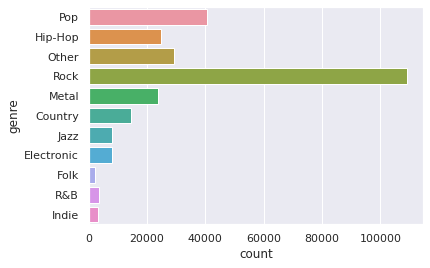

In [0]:
# code to merge 'Not Available' and 'Other' genres
cleanData.genre = cleanData.genre.apply(lambda x: x if x!='Not Available' else 'Other')
sb.countplot(y='genre', data = cleanData)

In [0]:
# remove Spanish songs from the dataset
cleanData = cleanData[~cleanData.song.str.contains("spanish")]
cleanData = cleanData[~cleanData.song.str.contains("spanglish")]
cleanData = cleanData.reset_index()
cleanData.drop('index', axis=1, inplace=True)

In [0]:
cleanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266404 entries, 0 to 266403
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   song    266404 non-null  object
 1   year    266404 non-null  int64 
 2   artist  266404 non-null  object
 3   genre   266404 non-null  object
 4   lyrics  266404 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.2+ MB


In [0]:
#Notice that there are some absurd values of year
cleanData[cleanData['year']<1960]

song  ...                                             lyrics
19620                  star  ...  You're my star It's such a wonder how you shin...
49981        anywhere-remix  ...  Here we are all alone You and me, privacy And ...
108170  it-s-over-now-remix  ...  What is this? Numbers in your pocket I remembe...
174837    come-see-me-remix  ...  Baby, you can come see me 'cause I need you he...
232410           let-s-lurk  ...     Still pulling up on smoke Skeng in my pocke...
246484      i-can-t-believe  ...    I can't believe that love has gone away from...

[6 rows x 5 columns]

In [0]:
#removing all such absurd values of year
cleanData = cleanData[cleanData['year']>1960]
cleanData = cleanData.reset_index()
cleanData.drop('index', axis=1, inplace=True)
cleanData.head()

song  ...                                             lyrics
0        ego-remix  ...  Oh baby, how you doing? You know I'm gonna cut...
1     then-tell-me  ...  playin' everything so easy, it's like you seem...
2          honesty  ...  If you search For tenderness It isn't hard to ...
3  you-are-my-rock  ...  Oh oh oh I, oh oh oh I    If I wrote a book ab...
4    black-culture  ...  Party the people, the people the party it's po...

[5 rows x 5 columns]

Notice that we have just dropped the rows for most of our unclean data rows. We can afford to do this because of the large size of the dataset with fairly clean values.

### **Exploratory Analysis and Visualization**
Since the dataset consists of unstructured text data and year is the only numeric data, there is not much visualization we can do without constructing our own features. However, we can at least use wordclouds to get a general idea of the majority sentiment of each genre, and we can use countplots, boxplots, and violinplots to get a brief idea of the data.

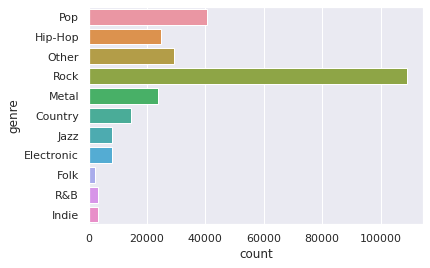

In [0]:
sb.countplot(y='genre', data = cleanData)

Rock songs clearly dominate the dataset, implying that we should perhaps limit our recommendation system when the user isn't listening to rock, to prevent it from interfering with other genres in the playlist.

In [0]:
#function to generate wordcloud for a dataframe
def show_wordclouds(data, title):
    text = ' '.join(data['lyrics'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600, collocations=False).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

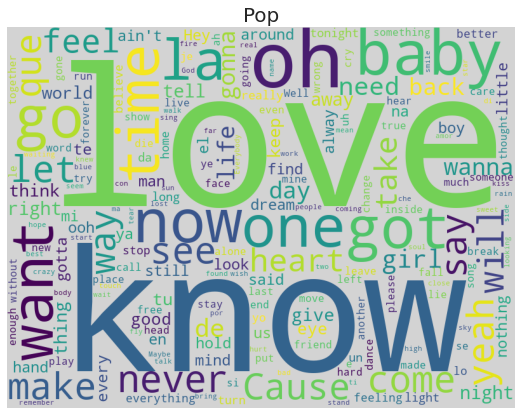

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Pop'],"Pop")

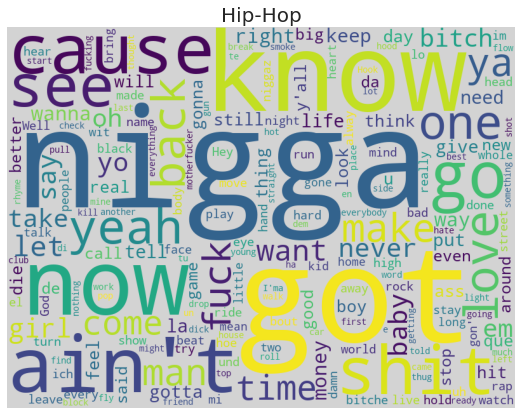

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Hip-Hop'],"Hip-Hop")

We can clearly see from the plot that Negative words are pretty dominant in hip-hop

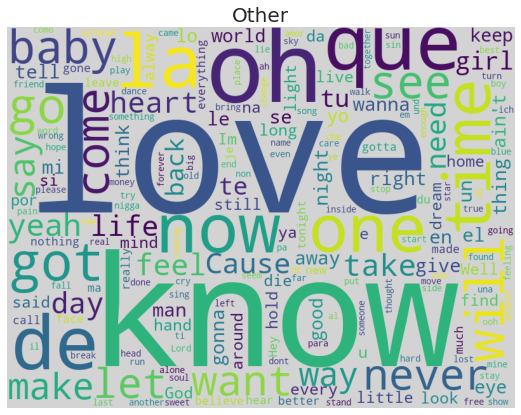

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Other'],"Other")

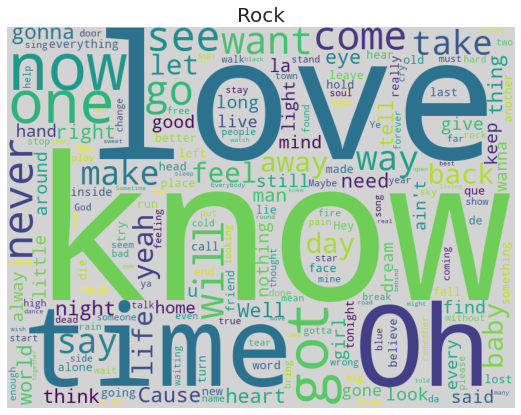

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Rock'],"Rock")

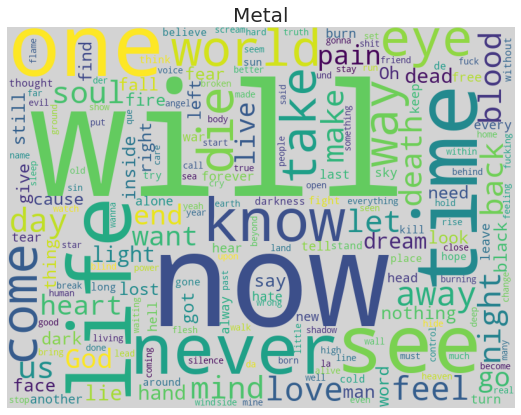

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Metal'],"Metal")

We notice that Metal songs use a wide range of words from the vocabulary

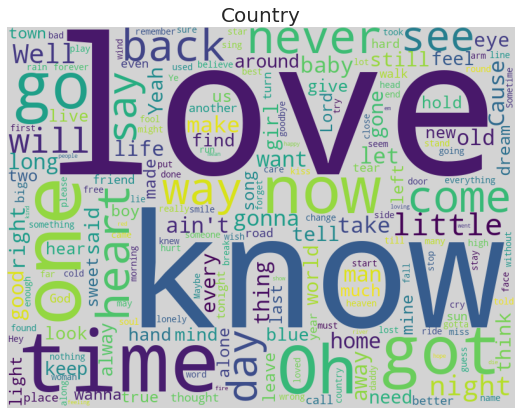

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Country'],"Country")

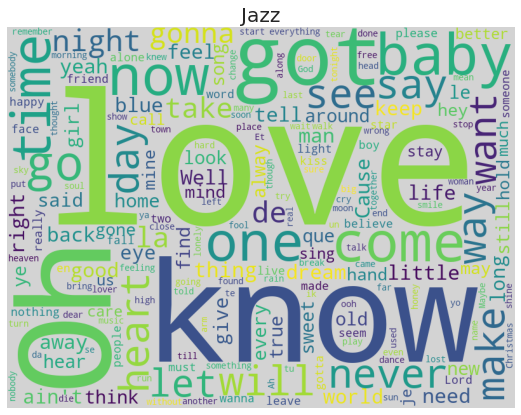

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Jazz'],"Jazz")

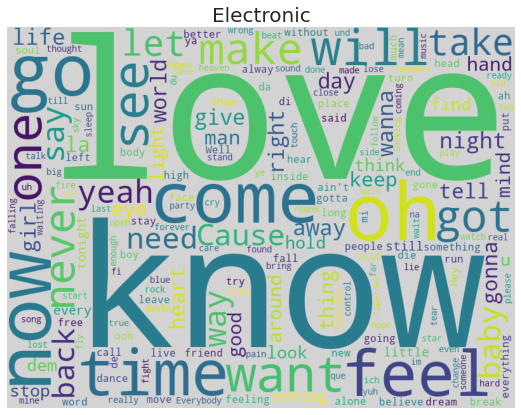

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Electronic'],"Electronic")

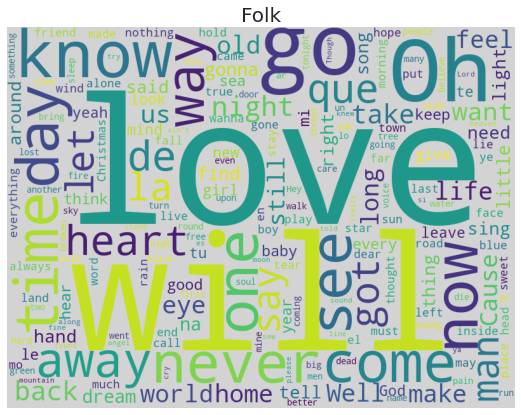

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Folk'],"Folk")

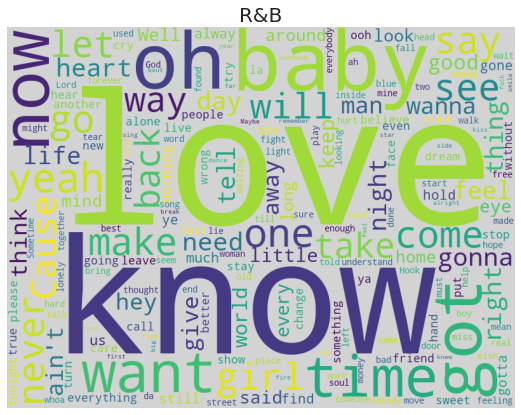

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'R&B'],"R&B")

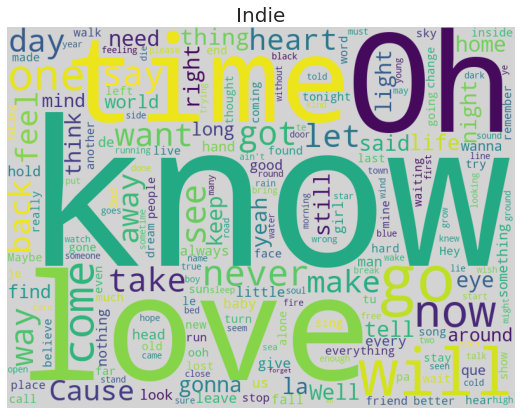

In [0]:
show_wordclouds(cleanData[cleanData['genre'] == 'Indie'],"Indie")

**Inference:** Hip-hop and Metal are clear standouts in terms of commonly used words. Other and Pop have very similar words to each other, implying that Other may consist of a significant amount of Pop. The remaining genres all seem to be centered around the words 'love','know','time' and 'now', perhaps implying that they would all gel well together sentiment-wise.

***Visualization of data with respect to year***

In [0]:
cleanData1 = pd.DataFrame(cleanData['year'].value_counts())
cleanData1['Index'] = cleanData1.index
cleanData1 = cleanData1.rename(columns={"year": "count", "Index": "year"})

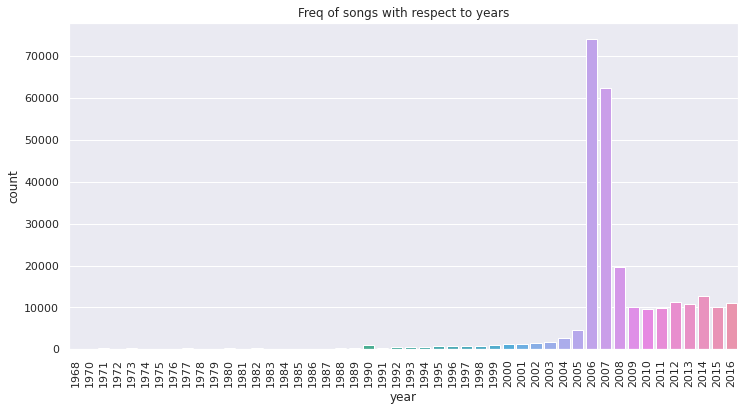

In [0]:
fig, ax = plt.subplots(figsize=(12, 6))
sb.barplot(x='year', y='count', 
            data=cleanData1, ax=ax)
plt.title("Freq of songs with respect to years")
plt.xticks(rotation='vertical');

We notice that the songs are mostly from around 2006 and 2007, although you can find songs too from other years too. The plots below show a distribution of songs from different genres through the years.

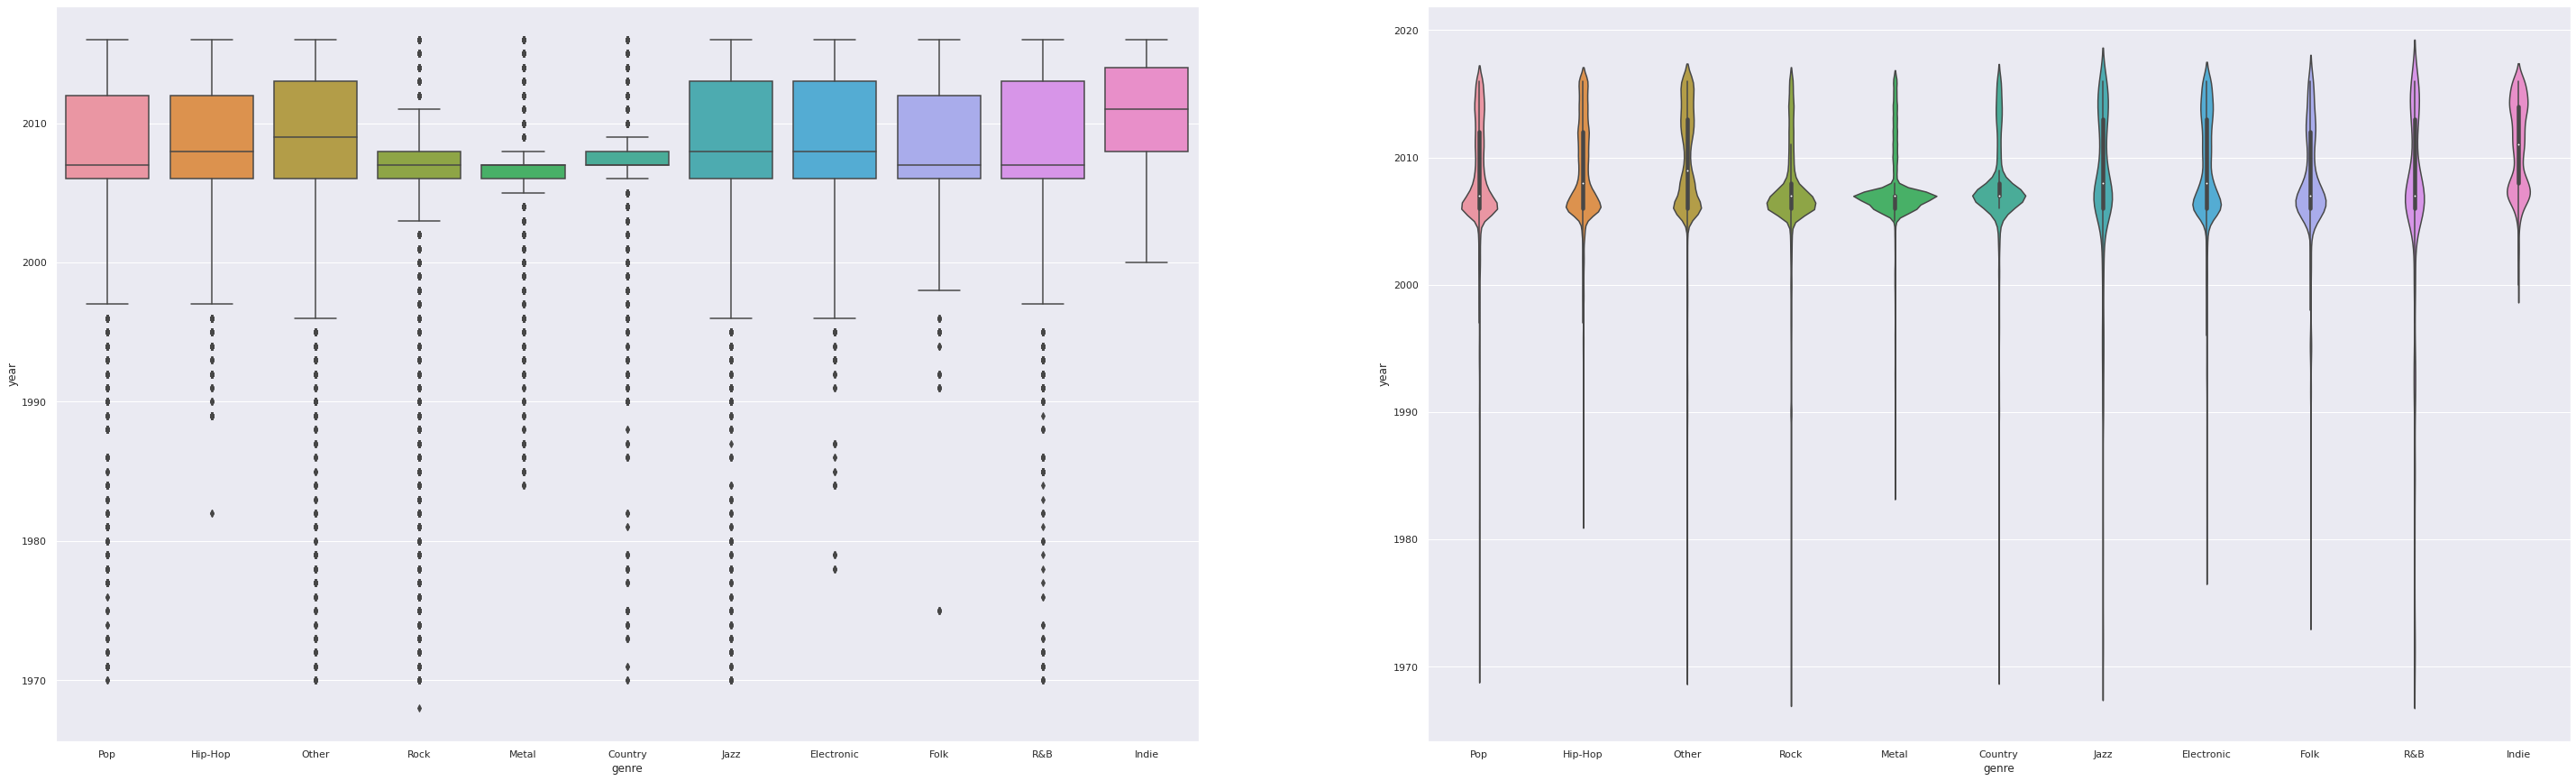

In [0]:
f, axes = plt.subplots(1, 2, figsize=(50, 15))
sb.boxplot(x='genre', y='year', data=cleanData, ax = axes[0])
sb.violinplot(x='genre',y='year',data=cleanData,ax=axes[1])

We notice that song genres like metal were popular only for a small period of time while pop songs are popular through the ages

### **Adding Sentiment Analysis**
Here, we use two different sentiment analysers - VADER from NLTK, and TextBlob. Both models are based on the same corpus, but give different results that we can use to our advantage, explained below.

In [0]:
sentiData = cleanData.copy()  # avoids damaging our clean dataset in case something goes wrong

In [0]:
#function to return TextBlob sentiment score (-1 to +1) for any string
def get_lyric_sentiment(lyrics):
  analysis = TextBlob(lyrics)
  return analysis.sentiment.polarity

In [0]:
#applying TextBlob sentiment analysis to each row's lyrics and appending the score to the dataset
sentiment = sentiData.apply(lambda row: get_lyric_sentiment(row['lyrics']), axis=1)
sentiData['Sentiment'] = sentiment

In [0]:
sentiData[:20]

song  ...  Sentiment
0                ego-remix  ...   0.148268
1             then-tell-me  ...   0.115729
2                  honesty  ...   0.004720
3          you-are-my-rock  ...   0.390422
4            black-culture  ...  -0.170833
5   all-i-could-do-was-cry  ...   0.336111
6       once-in-a-lifetime  ...   0.231081
7                  waiting  ...   0.240722
8                slow-love  ...   0.117628
9    why-don-t-you-love-me  ...   0.278853
10           save-the-hero  ...  -0.022917
11               telephone  ...  -0.016431
12         ice-cream-truck  ...   0.053947
13  no-broken-hearted-girl  ...  -0.096104
14                 control  ...   0.035065
15           i-m-alone-now  ...   0.207639
16                  poison  ...   0.024959
17        world-wide-women  ...   0.011486
18          beautiful-liar  ...   0.259965
19               bienvenue  ...   0.379575

[20 rows x 6 columns]

In [0]:
#Doing the same for the sentiment intensity analyser of VADER from NLTK
sid = SentimentIntensityAnalyzer()
sentiment2 = sentiData.apply(lambda row: sid.polarity_scores(row['lyrics'])['compound'], axis=1)
sentiData['Sentiment2'] = sentiment2

From the documentation of both these sentiment analysing algorithms, we found that TextBlob is a more advanced algorithm, because it uses the n-grams technique to do the analysis, while VADER uses the bag of words technique. Besides, TextBlob can handle some of the words from the 'spanish' corpus as well, unlike VADER. However, making use of both the techiques can help us in further refining the data, which will will discuss later.

In [0]:
sentiData.describe()  # gives us a general idea of the spread of the data

year      Sentiment     Sentiment2
count  266398.000000  266398.000000  266398.000000
mean     2007.695658       0.079404       0.153814
std         5.278447       0.186456       0.826323
min      1968.000000      -1.000000      -1.000000
25%      2006.000000      -0.015000      -0.840200
50%      2007.000000       0.060521       0.505300
75%      2010.000000       0.189276       0.963000
max      2016.000000       1.000000       1.000000

**Last bit of cleaning**

It came to our attention that there were many songs with multiple recordings, remixes, etc that had the exact same lyrics. To prevent our recommendation system from spamming the user with multiple variations of the same song, we used the functions below to ensure that only only one copy of each song exists (unless they have different lyrics)

In [0]:
repSongs = {}
indexList = []
repSongDF = sentiData.copy()
repSongDF.reset_index(inplace=True,drop=False)  # to get the 'index' column so we can make appropriate changes to sentiData later
repSongDF.sort_values(by=['Sentiment','index'],inplace=True)  # necessary to include 'index' so that first occurance is usually by original artist
repSongDF.reset_index(inplace=True,drop=True)
repSongDF.head()

index                 song  ...  Sentiment Sentiment2
0   1039             libertad  ...       -1.0    -0.6249
1   3186            liar-evil  ...       -1.0    -0.9979
2   3686              jugando  ...       -1.0    -0.9732
3   3716  el-duende-del-arbol  ...       -1.0    -0.9217
4   3724              presion  ...       -1.0    -0.6892

[5 rows x 8 columns]

In [0]:
#if both the sentiment scores of two songs match exactly, we add them to the list and dictioary
#since there are 6 decimal points to sentiment1 and 4 to sentiment2, we can be almost sure that the lyrics match exactly if the scores are equal.
for i in range((len(repSongDF)-1)):
  if (repSongDF['Sentiment'][i]==repSongDF['Sentiment'][i+1]) and (repSongDF['Sentiment2'][i]==repSongDF['Sentiment2'][i+1]):
    repSongs[repSongDF['index'][i]]=repSongDF['song'][i]
    repSongs[repSongDF['index'][i+1]]=repSongDF['song'][i+1]
    if repSongDF['index'][i] not in indexList:
      indexList.append(repSongDF['index'][i])
    if repSongDF['index'][i+1] not in indexList:
      indexList.append(repSongDF['index'][i+1])
print(len(repSongs))
print(len(indexList))  # making sure the number of songs match

39476
39476


In [0]:
print(repSongs)

{47599: 'einmal-mchte-ich-ein-bser-sein', 47605: 'einmal-mochte-ich-ein-boser-sein', 47615: 'bankduan-berfall', 47619: 'bankberfall', 50369: 'aun-sigo-viendo', 50376: 'an-sigo-viendo', 57643: 'luftstehs-lblh', 57653: 'luftstehs-lblcaeh', 124728: 'seraf', 124733: 'la-ladrona', 130893: 'te-imaginas', 130905: 'te-imaginas-radio-version', 148359: 'si-au00fan-te-quieres-quedar', 148394: 'si-aun-te-quieres-quedar', 167111: 'hritier', 167127: 'heritier', 251354: 'reggaeton-latino-remix', 251361: 'reggaeton-latino', 255378: 'a-thousand-miles-from-nowhere', 255445: 'thousand-miles-from-nowhere-1000-miles-from-nowhere', 216627: 'idiot', 263606: 'idiot', 167944: 'sua-c-ltame-las-riendas', 168034: 'sueltame-las-riendas', 231141: 'brr-it-s-cold-in-here-clovers', 231142: 'brr-it-s-cold-in-here', 246256: 'ironlung', 246278: 'ordinary-madness', 246282: 'collapse', 1106: 'evil-man-ii', 1159: 'evil-man', 106828: 'drop-the-hate-remixed-by-revhlidbo-and-the-progressive-baptist-choir-of-stockholm', 106849:

In [0]:
print(indexList)  # making sure order of indexes matches

[47599, 47605, 47615, 47619, 50369, 50376, 57643, 57653, 124728, 124733, 130893, 130905, 148359, 148394, 167111, 167127, 251354, 251361, 255378, 255445, 216627, 263606, 167944, 168034, 231141, 231142, 246256, 246278, 246282, 1106, 1159, 106828, 106849, 133634, 133750, 200333, 200343, 208716, 208736, 114451, 209538, 17455, 17566, 172928, 172935, 168895, 169192, 169218, 169404, 177370, 177384, 169155, 169365, 187185, 225213, 116431, 116464, 116511, 11014, 11016, 61040, 61043, 182348, 182636, 225086, 228939, 75154, 75169, 110736, 110737, 142404, 142410, 177535, 177557, 76218, 76219, 135719, 135762, 164173, 164210, 164211, 243830, 243870, 58937, 59130, 206960, 207108, 115691, 115693, 136598, 136655, 233408, 233410, 236131, 236135, 246271, 247535, 110361, 110373, 176812, 176821, 162119, 162265, 222857, 222897, 139313, 139318, 33269, 33331, 127847, 127848, 22784, 147483, 17534, 17571, 192786, 224913, 216739, 216760, 163388, 163389, 234301, 181070, 181078, 94079, 94184, 94190, 136438, 136453,

In [0]:
#removes multiple recordings of the same song, as in dict shown above
removeList = []
while True:  # repeats in case there are still duplicates left due to more than 2 recordings of the same song
  flag = 0
  for ptr in range((len(indexList)-1)):
    i = indexList[ptr]
    j = indexList[ptr+1]
    if (sentiData['Sentiment'][i]==sentiData['Sentiment'][j]) and (sentiData['Sentiment2'][i]==sentiData['Sentiment2'][j]):
      flag = 1
      #removes remix, otherwise removes song with shorter title, or the second appearance if titles have same length
      if ('remix' in sentiData['song'][i]) and ('remix' not in sentiData['song'][j]):
        removeList.append(i)
      elif ('remix' not in sentiData['song'][i]) and ('remix' in sentiData['song'][j]):
        removeList.append(j)
      elif len(sentiData['song'][i])<len(sentiData['song'][j]):
        removeList.append(i)
      else:
        removeList.append(j)
  if flag==0:  # breaks out of the while loop if there's nothing left to remove
    break
  removeList = list(set(removeList))  # removes duplicate values of indexes so there's no error
  indexList = [n for n in indexList if n not in removeList]  # updating indexList

print(len(removeList))  # so we know how many songs are being removed
sentiData.drop(sentiData.index[removeList],inplace=True)  # removing the songs

25648


In [0]:
sentiData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240750 entries, 1 to 266397
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   song        240750 non-null  object 
 1   year        240750 non-null  int64  
 2   artist      240750 non-null  object 
 3   genre       240750 non-null  object 
 4   lyrics      240749 non-null  object 
 5   Sentiment   240750 non-null  float64
 6   Sentiment2  240750 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 14.7+ MB


**Back to exploration/analysis of sentiment data**

In [0]:
sentiData['artist'].nunique()  # finds number of unique artists

14207

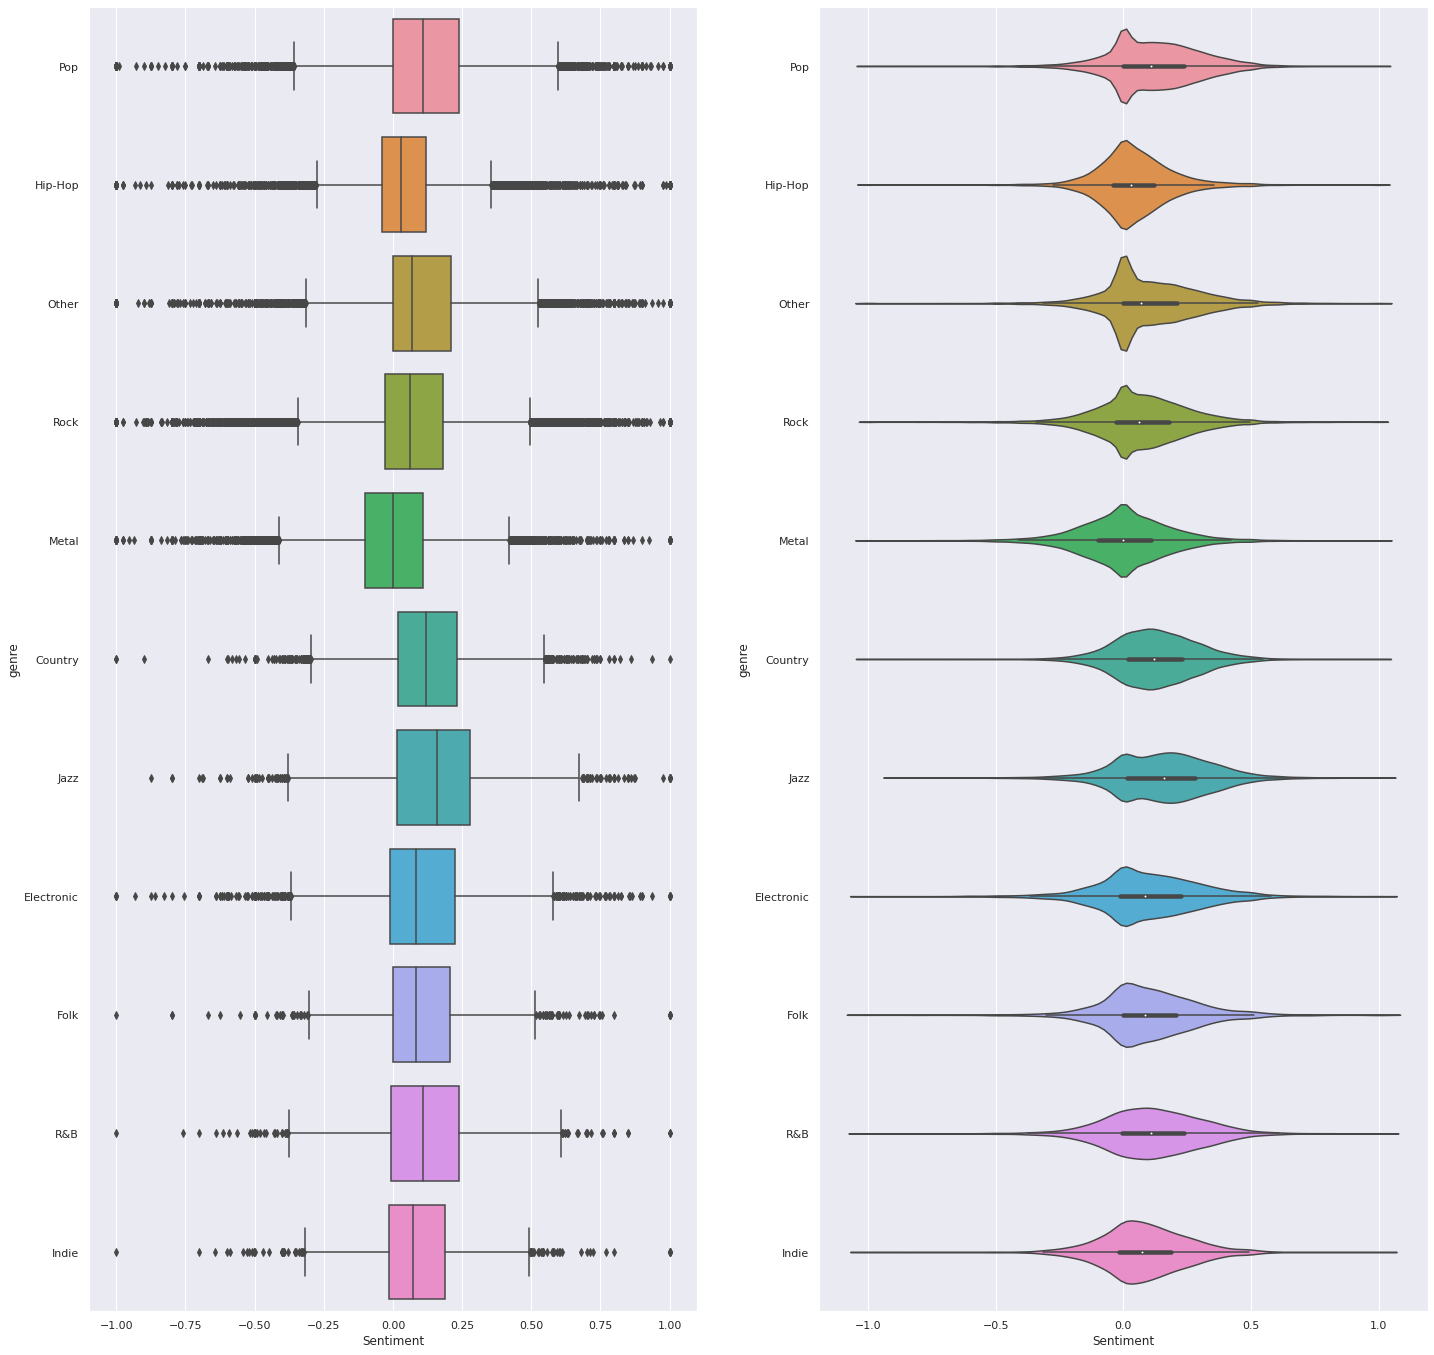

In [0]:
# No need to run again
f, axes = plt.subplots(1, 2, figsize=(24, 24))
sb.boxplot(x='Sentiment', y='genre', data=sentiData, ax=axes[0])
sb.violinplot(x='Sentiment', y='genre', data=sentiData, ax=axes[1])

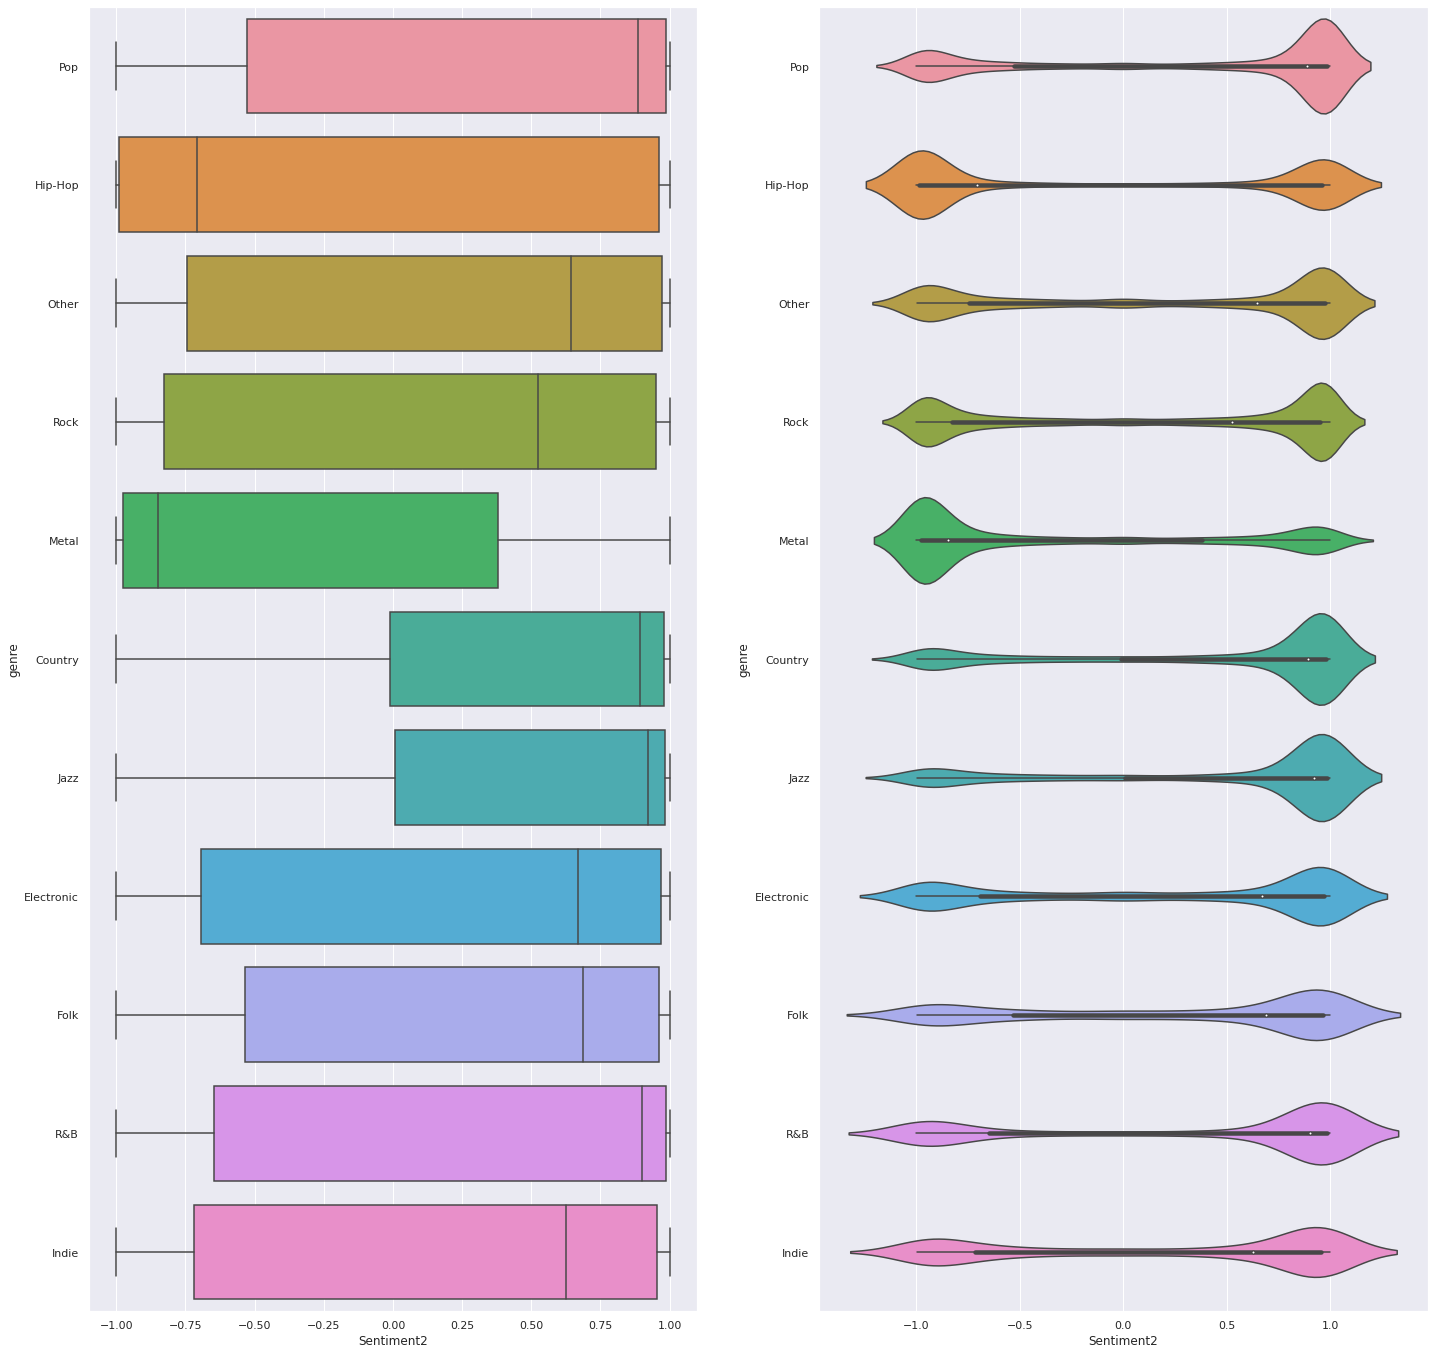

In [0]:
# No need to run again
f, axes = plt.subplots(1, 2, figsize=(24, 24))
sb.boxplot(x='Sentiment2', y='genre', data=sentiData, ax=axes[0])
sb.violinplot(x='Sentiment2', y='genre', data=sentiData, ax=axes[1])

From the above two plots, We notice that the TextBlob algorithm gave data that is generally centered around 0(Neutral- with slight deviations), with significant number outliers. On the other hand, the VADER analyser gave us data that has been labelled to either one of the extremes- positive or negative. 

However, if we compare the corresponding plots, we also find that the general distribution of data for Each genre is somewhat based on a similar sentiment: Metal and Hip-Hop are generally negative, and the rest are generally positive.

Let us do a correlation to check how similar the two are:


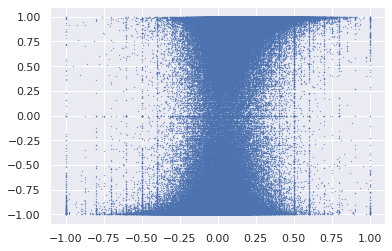

In [0]:
plt.scatter(sentiData['Sentiment'], sentiData['Sentiment2'], s=0.08)

In [0]:
corr_df = sentiData['Sentiment'].corr(sentiData['Sentiment2'])
print(corr_df)

0.4462621203919829


While the two sentiment data are not very similar, we get a good idea on the distribution of the songs based only on the two above two features.

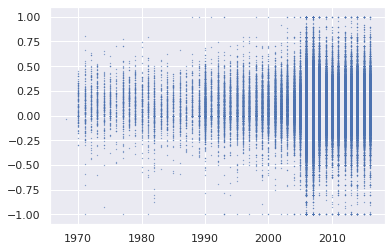

In [0]:
#Let us see how the sentiment varies across the year
plt.scatter(sentiData['year'], sentiData['Sentiment'], s=0.08)

We observe that in the 1970s uptill 2000s, the songs were mostly neutral, and they gradually started becoming extreme over the years.


Now that we have explored the data thoroughly, let us move on to making use of this data

In [0]:
#let us save the sentiment data, so that we do not need to run all these lines of code again.
sentiData.to_csv('/gdrive/My Drive/sentiDataFinal.csv', index=False)

## **Model-building, Testing, and Visualization of Results**
Make sure to import sentiData.csv if you haven't run the cells in the previous section

In [0]:
#the pre-processed data is stored in the file 'sentiDataFinal.csv'
sentiData = pd.read_csv('/gdrive/My Drive/sentiDataFinal.csv')
#sentiData = pd.read_csv('sentiDataFinal.csv') # uncomment this line and comment the other if running this notebook locally.

#### **Essential setup and model building**
The following code cells contain the final versions of the functions required to build and run our model

In [0]:
#normalizing the weightage given to the year by subtracting the mean from the data and dividing by standard deviation.
sMean = sentiData['year'].mean()
sStdev = sentiData['year'].std()
yearNorm = sentiData.year.apply(lambda x: (x-sMean)/(sStdev))
sentiData['yearNorm'] = yearNorm

In [0]:
sentiData.head()

song  year  ... Sentiment2  yearNorm
0            then-tell-me  2009  ...     0.9658  0.246978
1                 honesty  2009  ...     0.9698  0.246978
2         you-are-my-rock  2009  ...     0.9991  0.246978
3           black-culture  2009  ...     0.8659  0.246978
4  all-i-could-do-was-cry  2009  ...    -0.9337  0.246978

[5 rows x 8 columns]

In [0]:
sentiData.describe()

year      Sentiment     Sentiment2      yearNorm
count  240750.000000  240750.000000  240750.000000  2.407500e+05
mean     2007.722430       0.080115       0.148394  1.306232e-14
std         5.172805       0.188627       0.839064  1.000000e+00
min      1968.000000      -1.000000      -1.000000 -7.679089e+00
25%      2006.000000      -0.020000      -0.859800 -3.329779e-01
50%      2007.000000       0.065426       0.557400 -1.396592e-01
75%      2010.000000       0.191543       0.963600  4.402969e-01
max      2016.000000       1.000000       1.000000  1.600209e+00

To build the recommendation system, we have used two models to calculate the song similarities. First the basic Euclidean distance, and second Cosine similarity index. By combining the results from both these models, we were able to arrive at a meaningful, accurate recommendation playlist for the user.

This problem falls under the category of item-item similarity. We have used various features like the  two sentiment scores of the data, the artist, the genres and year of release as vectors for calculating and recommending the song. The features were normalised accordingly and a playlist was generated. The details have been mentioned in the comments below

In [0]:
#this function calculates the similarity by calculating eucledean distance between the two given songs
def get_eucDist(i, j):
  # Year, the 2 sentiment scores and genre have been considered as vectors(features) for this function.
  vec1 = [sentiData['yearNorm'][i]/100, sentiData['Sentiment'][i], sentiData['Sentiment2'][i]]
  vec2 = [sentiData['yearNorm'][j]/100, sentiData['Sentiment'][j], sentiData['Sentiment2'][j]]
   
  genreWt = 1/100 #normalization factor found by trial and error

  # We are simulating a kind of OH encoding over here
  if(sentiData['genre'][i]==sentiData['genre'][j]):
    vec1.append(genreWt)
    vec2.append(genreWt)
  else:
    vec1.append(genreWt)
    vec2.append(0)

  return(scpy.euclidean(vec1, vec2))


In [0]:
Eucd_data = sentiData.copy()  # initializing our euclidean distance dataset to use later

#running a loop to find the Euclidean distance between the given song and all other songs
def get_dist_songs(i):
  dist = Eucd_data.apply(lambda row: get_eucDist(i, row.name), axis=1)
  Eucd_data['Dist'] = dist
  Eucd_data.sort_values(by='Dist', ascending=True, inplace=True)

While this actually is a model by itself, it’s not a particularly great one and we use it instead to optimize and correct the flaws of the cosine similarity model.

In [0]:
#getting cosine similarity of the data, similar to eucledean distance 
def get_cosSim(i, j, sliderVal, wt):
  vec1 = [sentiData['yearNorm'][i]/100, sentiData['Sentiment'][i], sentiData['Sentiment2'][i]]
  vec2 = [sentiData['yearNorm'][j]/100, sentiData['Sentiment'][j], sentiData['Sentiment2'][j]]
  #simulating OH encoding for artist and genre without actually doing it

  # The artist weight is normalised by a process similar it TF-IDF, 
  # where wt is the square root of the frequency of the artist(ie, number of songs he has played)
  # the slider value is given so that the User can adjust if he wants the weightage of the song to be high or not
  artistWt = 0.8*(1-sliderVal)/wt  # found by trial and error, see old tests

  genreWt = 0.001   # found by trial and error, keeping genres more or less balanced

  if(sentiData['artist'][i]==sentiData['artist'][j]):
    vec1.append(artistWt)
    vec2.append(artistWt)
  else:
    vec1.append(artistWt)
    vec2.append(0)

#encoding of genre similar to that in the euclidean distance
  if(sentiData['genre'][i]==sentiData['genre'][j]):
    vec1.append(genreWt)
    vec2.append(genreWt)
  else:
    vec1.append(genreWt)
    vec2.append(0)

  return(pw.cosine_similarity([vec1],[vec2])[0][0])

In [0]:
# gets the cosine similarity for the top 10% closest songs(eucledean) to a given song
def get_nearest_neighbor(i, sliderVal):
  #important: testerData is a local variable, does not effect the outside testerData
  #that's why we return the dataframe
  testerData = Eucd_data[:(len(sentiData)//test_splitfactor*10)].copy()

  #groups of  similar genres are created, so that genres with very few songs are not overshadowed
  #(Refer to the explanation in the exploratory analysis section)
  genre = sentiData.iloc[i]['genre']
  if genre in ['Jazz','R&B','Indie','Electronic']:
    testerData = testerData[testerData['genre']==genre]
  elif genre in ['Pop','Hip-Hop']:
    testerData = testerData[testerData['genre'].isin(['Pop','Hip-Hop','Other'])]
  elif genre in ['Rock','Metal']:
    testerData = testerData[testerData['genre'].isin(['Rock','Metal','Other'])]
  elif genre in ['Country','Folk']:
    testerData = testerData[testerData['genre'].isin(['Country','Folk','Other'])]

  #weightage for the song normalization (refer to get_cosSim())
  wt = len(sentiData[sentiData.artist == sentiData['artist'][i]])**0.5

  #model calculation
  score = testerData.apply(lambda row: get_cosSim(i, row.name, sliderVal, wt), axis=1)
  testerData['Score'] = score
  testerData.sort_values(by='Score', ascending=False, inplace=True)
  return testerData

By applying Euclidean distance first, we’re able to select a subset of the dataset ( that is the top 10% of Euclidean distances), greatly optimizing the time taken to run the cosine  function.  (initially, only cosine distance took around 2-3 minutes to generate the playlist, but the new combined Euclidean-cosine model takes only around 40 seconds)

An added bonus, it also prevents our system from recommending dissimilar songs that have feature vectors that are direct multiples of each other - a very real problem that we faced when we first tried to apply cosine distances directly.(refer to old tests)

In [0]:
#function to handle cases if the user does not type the complete name of artist or song
#it predicts possible songs the user may be looking for.
def search_list_predict(term_list, search_term):
  filtered_list=[x for x in term_list if x.startswith(search_term)]
  filtered_list.extend([x for x in term_list if (search_term in x) and (x not in filtered_list)])
  filtered_set=set(filtered_list)
  filtered_list=list(filtered_set)
  return filtered_list

print(search_list_predict(sentiData['song'], 'good-ones'))

['good-ones-go', 'cameras-good-ones-go-interlude', 'good-ones-and-bad-ones']


In [0]:
# Search function to search the song with name of song and artist with artist name optional
def get_info(songName, artistName=None):
  #case when the user does not enter artist name
  if artistName==None:
    #if exact match of song is found
    if len(sentiData[sentiData['song'] == songName]):
      return sentiData[sentiData['song'] == songName]
    else:
       #there is no exact match of the song, so it tries to see if there could be other possibilities
       #if there are no other possibilities, an error message is returned.
      possible_song_names=search_list_predict(sentiData['song'], songName)
      if(len(possible_song_names)==0):
        print('Error: song not found')
        return -1
      else:
        df=pd.DataFrame()
        for x in possible_song_names:
          df=pd.concat([df, sentiData[sentiData['song']==x]], axis=0)
        return df
  #case when both song and artist is entered      
  else:
    #if exact match is found:
    if len(sentiData[(sentiData['song'] == songName)&(sentiData['artist'] == artistName)]):
      return sentiData[(sentiData['song'] == songName)&(sentiData['artist'] == artistName)]
    #if artist name is correct but song name is incomplete, then it predicts a possible song  
    elif len(sentiData[sentiData['artist'] == artistName]):
      possible_song_names=search_list_predict(sentiData['song'], songName)
      if(len(possible_song_names)==0):
        print('Error: song not found')
        return -1
      else:
        df=pd.DataFrame()
        for x in possible_song_names:
            df=pd.concat([df, sentiData[(sentiData['song']==x)&(sentiData['artist'] == artistName)]], axis=0)
            if len(df)== 0:
              print('Error: song not found')
              return -1
            else:
              return df
    #if Song name matches and artist does not match, it predicts a possible artist          
    elif len(sentiData[sentiData['song'] == songName]):
      possible_artist_names=search_list_predict(sentiData['artist'], artistName)
      df=pd.DataFrame()
      for y in possible_artist_names:
            df=pd.concat([df, sentiData[(sentiData['song']==songName)&(sentiData['artist'] == y)]], axis=0)
      if len(df)== 0:
              return sentiData[sentiData['song'] == songName]
      else:
              return df
      
    #if both dont match, it predicts both
    else:
      possible_song_names=search_list_predict(sentiData['song'], songName)
      possible_artist_names=search_list_predict(sentiData['artist'], artistName)
      if(len(possible_song_names)==0):
        print('Error: song not found')
        return -1
      else:
        df=pd.DataFrame()
        for x in possible_song_names:
          for y in possible_artist_names:
            df=pd.concat([df, sentiData[(sentiData['song']==x)&(sentiData['artist'] == y)]], axis=0)
        if len(df)== 0:
              print('Error: song not found')
              return -1
        else:
              return df

get_info('the-one','elton-john')

song  year      artist  ... Sentiment Sentiment2  yearNorm
218429  the-one  2006  elton-john  ...  0.138462     0.9744 -0.332978

[1 rows x 8 columns]

#### **Trial and error testing and improvements**
The below code cells show various tests we did in the process of designing our final model, with explanations for the problems we faced and what caused us to implement certain parts of the final model. Do go through the explanations for better understanding of our thought process throughout.

**Important: do NOT re-run these cells.** The following cells were only used for fine-tuning our model. Since they use older versions of our functions, **they will not work if they are run again.**

**Test #1:** the below test was using Euclidean distances only. It gives us a proper playlist of similar songs, but the model isn't particularly great and can definitely be imporved on.

In [0]:
# THESE ARE OLD TESTS THAT WON'T WORK NOW, DO NOT RUN AGAIN
get_dist_songs(12)

In [0]:
# THESE ARE OLD TESTS THAT WON'T WORK NOW, DO NOT RUN AGAIN
Eucd_data[:30]

song  ...      Dist
12                                        ice-cream-truck  ...  0.000000
211                                          kick-him-out  ...  0.002055
117442                                             in-l-a  ...  0.002416
76664                                    hold-up-my-heart  ...  0.002851
84873   it-must-really-suck-to-be-four-year-strong-rig...  ...  0.002913
169978                                      wild-at-heart  ...  0.003289
212354                                       crazy-not-to  ...  0.003310
194359                                            forever  ...  0.003509
211912                                         forgive-me  ...  0.003631
204728                                              reset  ...  0.003931
11941                                           follow-me  ...  0.004050
254103                                  time-the-magician  ...  0.004100
138426                                        replace-you  ...  0.004236
5459                                              hey-you  ...  0.004521
144594                             getting-into-something  ...  0.004789
76158                                         on-my-knees  ...  0.004828
226131                                    the-other-woman  ...  0.004845
221351           what-did-i-have-that-i-donaeur-tm-t-have  ...  0.005125
264859                                       i-get-around  ...  0.005258
254040                                  cold-wind-blowing  ...  0.005261
116125                                 the-woman-you-love  ...  0.005486
225420                                            swingin  ...  0.005605
185493      why-have-you-left-the-one-you-left-for-me-for  ...  0.005630
115313                        trains-and-boats-and-planes  ...  0.005683
23527                                   different-summers  ...  0.005918
170115                                     in-the-country  ...  0.006040
170086                                         crazy-days  ...  0.006108
116436                                      hold-on-to-me  ...  0.006130
207867                                   bricks-and-steel  ...  0.006240
12422                             we-both-know-they-exist  ...  0.006301

[30 rows x 9 columns]

**Test #2:** The below test was our first completed attempt at cosine function model (no Euclidean), using (simulated) OH encoding for both genre and artist with no weightages.

Notice how the playlist is entirely dominated by the same artist and same year, this is a major problem and the reason we used weights instead of simply using OH encoding the categorical variables.

In [0]:
# THESE ARE OLD TESTS THAT WON'T WORK NOW, DO NOT RUN AGAIN
get_nearest_neighbor(1)

In [0]:
# THESE ARE OLD TESTS THAT WON'T WORK NOW, DO NOT RUN AGAIN
testerData[:30]

song  year  ... Sentiment2     Score
1                         then-tell-me  2009  ...     0.9658  1.000000
197                     settle-for-you  2008  ...     0.9706  0.999934
221                              radio  2008  ...     0.9903  0.999887
73034                           winter  2009  ...     0.9659  0.999873
47325             the-boy-does-nothing  2009  ...     0.9646  0.999868
167026                    i-never-knew  2009  ...     0.9723  0.999866
76                         blind-trust  2010  ...     0.9920  0.999860
23484                   stop-the-world  2009  ...     0.9565  0.999860
8                            slow-love  2009  ...     0.9996  0.999859
9023                       how-we-roll  2009  ...     0.9646  0.999856
116449                       sometimes  2009  ...     0.9780  0.999852
180511             bet-you-didn-t-know  2009  ...     0.9532  0.999844
93603                         hot-mess  2009  ...     0.9538  0.999843
174896          that-s-alright-with-me  2008  ...     0.9643  0.999842
228742            you-are-what-you-are  2010  ...     0.9649  0.999842
14580                        certified  2009  ...     0.9503  0.999842
23609                    1-2-3-goodbye  2008  ...     0.9680  0.999841
23494                remember-december  2009  ...     0.9759  0.999841
170458                    friday-night  2009  ...     0.9817  0.999840
60075                     running-away  2010  ...     0.9670  0.999840
96820            those-good-old-dreams  2009  ...     0.9604  0.999840
118583              throw-in-the-towel  2009  ...     0.9808  0.999840
8825                     just-one-tear  2009  ...     0.9694  0.999838
47323                  cinderella-shoe  2009  ...     0.9550  0.999837
89241                        here-i-am  2008  ...     0.9690  0.999837
97101                      immortality  2010  ...     0.9643  0.999835
226                         nasty-girl  2008  ...     0.9976  0.999832
189052       first-time-for-everything  2008  ...     0.9621  0.999832
121280         heaven-s-light-hellfire  2008  ...     0.9740  0.999832
216166  it-s-only-the-end-of-the-world  2008  ...     0.9703  0.999831

[30 rows x 8 columns]

**Test #3:** This was a trial playlist made using only Sentiment and Sentiment2 in the cosine function.

There is a major problem with this playlist - many songs are assigned a perfect similarity score despite being completely different, as their feature vectors are direct multiples of each other.

Due to this problem, we decided to use both Euclidean and Cosine distance functions to prevent something like this happening again.

In [0]:
# THESE ARE OLD TESTS THAT WON'T WORK NOW, DO NOT RUN AGAIN
get_nearest_neighbor(1) #done using only sentiment 1 and 2, clearly bad since score is 1 when vectors are direct multiples of one another.
testerData[:30]

song  year  ... Sentiment2 Score
1                                        then-tell-me  2009  ...     0.9658   1.0
259504                                 inside-my-room  2006  ...     0.9211   1.0
162031                      prohibition-4th-amendment  2007  ...     0.9160   1.0
184084                                         travel  2005  ...     0.9768   1.0
38104                                   on-the-b-side  2006  ...     0.9673   1.0
39681           fantastic-voyage-original-version-mix  2006  ...     0.8458   1.0
39677                     fantastic-voyage-timber-mix  2006  ...     0.8458   1.0
39626                                fantastic-voyage  2006  ...     0.8458   1.0
106415                                      a-hostage  2007  ...     0.1808   1.0
184236                                your-glasshouse  2008  ...     0.9763   1.0
246835                       rhythm-of-your-heartbeat  2007  ...     0.9869   1.0
248347                                    georgie-ray  2011  ...     0.9628   1.0
81167                              my-biggest-mistake  2008  ...     0.9506   1.0
27248   bobbie-lee-what-s-the-difference-i-gotta-live  2007  ...     0.9695   1.0
197950                             morning-has-broken  2006  ...     0.9896   1.0
80458                             like-this-like-that  2010  ...     0.9940   1.0
98439                                       saddle-up  2008  ...     0.9680   1.0
248860                                         hunger  2008  ...     0.9889   1.0
265659                                the-peddler-man  2007  ...     0.9933   1.0
86829                                      poker-face  2009  ...     0.9773   1.0
122790                     if-she-knew-what-she-wants  2006  ...     0.8393   1.0
69140                                the-long-goodbye  2006  ...     0.9976   1.0
47937                                 bossa-nova-baby  2003  ...     0.9420   1.0
72579                                      moon-stars  2010  ...     0.8343   1.0
223485                                    stand-still  2006  ...     0.9461   1.0
82267                                      impossible  2012  ...     0.9949   1.0
74543                                      mango-tree  2007  ...     0.7184   1.0
31168                             i-want-my-life-back  2012  ...     0.4556   1.0
149698                 i-got-a-mind-to-give-up-living  2015  ...     0.4767   1.0
40541                                       raincloud  2006  ...     0.8776   1.0

[30 rows x 8 columns]

**Test #4:** This model used only cosine function, but used something similar to TF-IDF weightage for the artist.

Notice that directly dividing by term frequency has an effect too powerful, and none of the artists after the first song are the original artist. While this could be useful, not all users may want that. So, it made us use a user-input slider for artist diversity instead.

Also notice how the years are very close to one another and genre is all pop, due to which we needed to further balance our year and genre weightages.

In [0]:
# THESE ARE OLD TESTS THAT WON'T WORK NOW, DO NOT RUN AGAIN
get_nearest_neighbor(1, len(testerData[testerData.artist == sentiData['artist'][1]]))
testerData[:30]

song  year  ... Sentiment2     Score
1                         then-tell-me  2009  ...     0.9658  1.000000
73034                           winter  2009  ...     0.9659  0.999995
47325             the-boy-does-nothing  2009  ...     0.9646  0.999991
167026                    i-never-knew  2009  ...     0.9723  0.999988
23484                   stop-the-world  2009  ...     0.9565  0.999981
9023                       how-we-roll  2009  ...     0.9646  0.999980
116449                       sometimes  2009  ...     0.9780  0.999974
174896          that-s-alright-with-me  2008  ...     0.9643  0.999970
228742            you-are-what-you-are  2010  ...     0.9649  0.999970
23609                    1-2-3-goodbye  2008  ...     0.9680  0.999969
60075                     running-away  2010  ...     0.9670  0.999968
96820            those-good-old-dreams  2009  ...     0.9604  0.999967
180511             bet-you-didn-t-know  2009  ...     0.9532  0.999966
93603                         hot-mess  2009  ...     0.9538  0.999966
23494                remember-december  2009  ...     0.9759  0.999966
8825                     just-one-tear  2009  ...     0.9694  0.999965
89241                        here-i-am  2008  ...     0.9690  0.999965
97101                      immortality  2010  ...     0.9643  0.999964
14580                        certified  2009  ...     0.9503  0.999963
118583              throw-in-the-towel  2009  ...     0.9808  0.999962
47323                  cinderella-shoe  2009  ...     0.9550  0.999962
189052       first-time-for-everything  2008  ...     0.9621  0.999961
170458                    friday-night  2009  ...     0.9817  0.999961
216166  it-s-only-the-end-of-the-world  2008  ...     0.9703  0.999960
121280         heaven-s-light-hellfire  2008  ...     0.9740  0.999959
252127                      i-have-you  2008  ...     0.9582  0.999959
116158                       mrs-so-so  2008  ...     0.9734  0.999958
73037                    horny-hippies  2009  ...     0.9716  0.999958
116621                        memories  2010  ...     0.9660  0.999957
5070       never-want-to-say-it-s-love  2008  ...     0.9719  0.999956

[30 rows x 8 columns]

**Test #5:** This was a test fairly close to our final model, applying all the same techniques we used for our final model.

The only difference is that despite a slider value of 0.7 (more diverse) there's still a lot of the original artist, and the genre is mostly the same initially.

This test led us to further rebalance our artist weightage, and then start shuffling the songs a little to give more variety to the listener throughout the playlist.

In [0]:
# THESE ARE OLD TESTS THAT WON'T WORK NOW, DO NOT RUN AGAIN
testPlaylist = get_nearest_neighbor(12,0.7)

In [0]:
# THESE ARE OLD TESTS THAT WON'T WORK NOW, DO NOT RUN AGAIN
testPlaylist[:30]

song  year  ...      Dist     Score
12                               ice-cream-truck  2009  ...  0.000000  1.000000
211                                 kick-him-out  2008  ...  0.002055  0.999998
106                             in-da-club-remix  2006  ...  0.016674  0.999966
79                                     ice-cream  2010  ...  0.019496  0.999903
141                                   in-da-club  2006  ...  0.020804  0.999882
32                     bonnie-and-clyde-ft-jay-z  2007  ...  0.035914  0.999873
52                                    superpower  2013  ...  0.021101  0.999858
14                                       control  2009  ...  0.018883  0.999817
158                                      freedom  2016  ...  0.023882  0.999803
86                                    speechless  2006  ...  0.025773  0.999732
232                                      next-ex  2008  ...  0.032983  0.999488
124                          sexy-lil-thug-remix  2006  ...  0.037672  0.999422
126                       that-s-how-you-like-it  2006  ...  0.039440  0.999379
108     get-me-bodied-extended-remix-bonus-track  2006  ...  0.038470  0.999283
132437                         last-night-part-2  2009  ...  0.009714  0.999232
14567                                rough-me-up  2009  ...  0.007305  0.999232
14563                                 ruff-me-up  2009  ...  0.007305  0.999232
74788                           i-wanna-know-you  2009  ...  0.016900  0.999232
53591                           i-do-not-hook-up  2009  ...  0.030312  0.999232
19576                                   champion  2009  ...  0.013862  0.999231
210837                                marco-polo  2009  ...  0.011854  0.999231
76664                           hold-up-my-heart  2009  ...  0.002851  0.999231
58380                                     rewind  2009  ...  0.017363  0.999231
213768                                   saviour  2009  ...  0.015243  0.999231
2013                                take-me-home  2009  ...  0.040154  0.999231
210855                                  she-s-my  2009  ...  0.010417  0.999231
89412                             i-miss-my-love  2009  ...  0.014363  0.999231
245000                              hole-to-feed  2009  ...  0.028482  0.999231
114287                                  homeless  2010  ...  0.009422  0.999230
214459                               100-million  2009  ...  0.012208  0.999230

[30 rows x 10 columns]

#### **Final Model**
The cells below demonstrate our final music recommendation system model.

In [0]:
get_info('hotline-bling')  # use get_info(song, artist) to get the index for the song you want to create a playlist for
# artist name is optional, may return multiple songs of the same/similar name so choose the one you want

song  year artist  ... Sentiment Sentiment2  yearNorm
171948  hotline-bling  2015  drake  ... -0.010351     0.9898   1.40689

[1 rows x 8 columns]

In [0]:
# RUN THE CODE BELOW TO GENERATE PLAYLISTS USING DIFFERENT VALUES FOR ind AND slider:
ind = 171948  #User inputs the song, and and index is taken accordingly
#for this code cell, simply use the index of the song you're listening to from the code cell above.                                                                              
slider = 0.5  #User input: higher means more diverse artist mix, 0 to 1, default=0.5
get_dist_songs(i)
testPlaylist = get_nearest_neighbor(ind, slider)
testPlaylist = testPlaylist[:30] #The playlist takes the top 30 nearest songs based on both models
testPlaylist.reset_index(inplace=True)
testPlaylist = pd.concat([testPlaylist[:6], testPlaylist[6:].sample(frac=1)])  # shuffles songs 6-30 so there's variety and not just the same artist
testPlaylist.reset_index(inplace=True, drop=True)
testPlaylist

index                            song  year  ...  yearNorm      Dist     Score
0   171948                   hotline-bling  2015  ...  1.406890  0.000000  1.000000
1   171793            nothing-was-the-same  2013  ...  1.020253  0.024065  0.999980
2   171928  cameras-good-ones-go-interlude  2011  ...  0.633616  0.012225  0.999960
3   171898                4pm-in-calabasas  2016  ...  1.600209  0.021106  0.999958
4   171979             bar-mitzvah-in-1999  2014  ...  1.213572  0.032383  0.999942
5   171943                       on-a-wave  2015  ...  1.406890  0.025466  0.999933
6   171958                change-locations  2015  ...  1.406890  0.038836  0.999298
7   171949                 6pm-in-new-york  2015  ...  1.406890  0.041284  0.999779
8   171683                            fear  2009  ...  0.246978  0.014167  0.999929
9   171902                    child-s-play  2016  ...  1.600209  0.022495  0.999768
10  171966        teach-you-a-lesson-remix  2008  ...  0.053659  0.087794  0.999628
11  171878                       fake-love  2016  ...  1.600209  0.035482  0.999365
12  171781                  305-to-my-city  2013  ...  1.020253  0.087233  0.999685
13  171882                     you-with-me  2016  ...  1.600209  0.111018  0.999831
14  171717              friends-with-money  2009  ...  0.246978  0.055590  0.999742
15  171796                     put-it-down  2010  ...  0.440297  0.029257  0.999585
16  171946                          preach  2015  ...  1.406890  0.091212  0.999909
17  171892                      redemption  2016  ...  1.600209  0.031880  0.999501
18  171768         started-from-the-bottom  2013  ...  1.020253  0.071933  0.999798
19  171960                        10-bands  2015  ...  1.406890  0.035844  0.999407
20  171900          back-to-back-freestyle  2016  ...  1.600209  0.022556  0.999830
21  171778       the-start-from-the-bottom  2013  ...  1.020253  0.071830  0.999807
22  171691                       the-usual  2009  ...  0.246978  0.041748  0.999315
23  171843                         cameras  2012  ...  0.826934  0.027539  0.999663
24  171699                       slow-down  2009  ...  0.246978  0.030722  0.999839
25  171864                   marvin-s-room  2012  ...  0.826934  0.154612  0.999397
26  171790              girls-love-beyonce  2013  ...  1.020253  0.029864  0.999555
27  171799                   same-mistakes  2010  ...  0.440297  0.045667  0.999549
28  171877                               9  2016  ...  1.600209  0.027103  0.999626
29  171754            it-s-been-a-pleasure  2009  ...  0.246978  0.015893  0.999875

[30 rows x 11 columns]

#### **PCA and t-SNE Visualization of map**
Since our model uses OH encoding, the 'map' that our recommendation system uses is multidimensional and can't be visualized directly. So, we use two different dimension reducing algorithms - PCA (Principal Component Analysis) and t-SNE (t-distributed Stochastic Neighbor Embedding) - to visualize it in a form that we can understand.

In [0]:
#we've only simulated OH encoding so far for the sake of efficiency, but here we actually do it
#as these OH columns will be 'features' for fitting the PCA and t-SNE models.
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(sentiData[['genre']]))
OH_cols.index = sentiData.index

In [0]:
#creating a separate dataset to apply PCA on, with the OH columns included
pcaData = pd.concat([sentiData, OH_cols], axis=1, sort=False)
pcaData.head()

song  year           artist genre  ...    7    8    9   10
0            then-tell-me  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0
1                 honesty  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0
2         you-are-my-rock  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0
3           black-culture  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0
4  all-i-could-do-was-cry  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0

[5 rows x 19 columns]

In [0]:
pcaData.info()  # ensuring there are no NaNs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240750 entries, 0 to 240749
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   song        240750 non-null  object 
 1   year        240750 non-null  int64  
 2   artist      240750 non-null  object 
 3   genre       240750 non-null  object 
 4   lyrics      240749 non-null  object 
 5   Sentiment   240750 non-null  float64
 6   Sentiment2  240750 non-null  float64
 7   yearNorm    240750 non-null  float64
 8   0           240750 non-null  float64
 9   1           240750 non-null  float64
 10  2           240750 non-null  float64
 11  3           240750 non-null  float64
 12  4           240750 non-null  float64
 13  5           240750 non-null  float64
 14  6           240750 non-null  float64
 15  7           240750 non-null  float64
 16  8           240750 non-null  float64
 17  9           240750 non-null  float64
 18  10          240750 non-null  float64
dtypes:

In [0]:
#creating and fitting the PCA model
pca = PCA(n_components=3)  # n-components refers to the number of vectors in the basis that PCA creates for the data.
#Here, we use 3 as we only wish to view 2D and 3D plots directly.
pca_result = pca.fit_transform(pcaData[(['Sentiment','Sentiment2','yearNorm']+list(range(11)))].values)
pcaData['pca-one'] = pca_result[:,0]
pcaData['pca-two'] = pca_result[:,1] 
pcaData['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
#the above line prints the variance explained by each of the 3 principal component vectors, in descending order.

Explained variation per principal component: [0.40229342 0.28602306 0.11045723]


Notice that the first two components explain ~69% of the variance, and with the third, ~80% is explained. This implies that despite the dimensional reduction, most of the data variance has been preserved and we will have a fairly accurate representation.

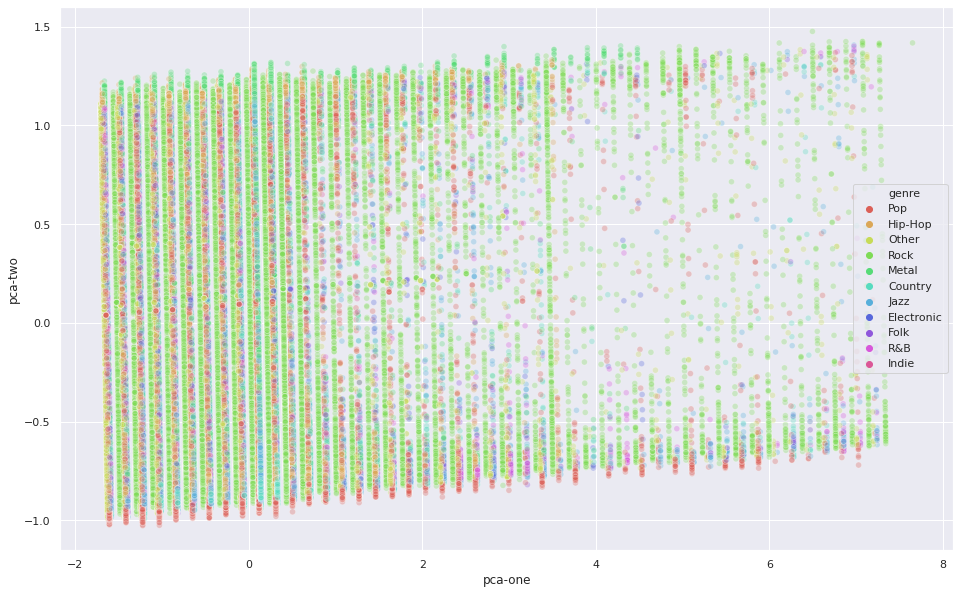

In [0]:
#plotting a 2D figure with the first two components
plt.figure(figsize=(16,10))
sb.scatterplot(
    x="pca-one", y="pca-two",
    hue="genre",
    palette=sb.color_palette("hls", 11),
    data=pcaData,
    legend="full",
    alpha=0.3
)

Although the above figure is supposed to explain ~69% of the variance, it's pretty hard to understand for humans and we can't really see any patterns forming.

So, let's look at a 3D plot instead.

In [0]:
#we must label encode the genre as well, in order to display the colors properly in the plot below.
labelEnc = {'Other':0,'Rock':1, 'Pop':2,'Country':3,'Metal':4,'Hip-Hop':5,'Indie':6,'Electronic':7,'Jazz':8,'R&B':9,'Folk':10}
genreLabel = pcaData.genre.apply(lambda x: labelEnc[x])
pcaData['genreLabel'] = genreLabel

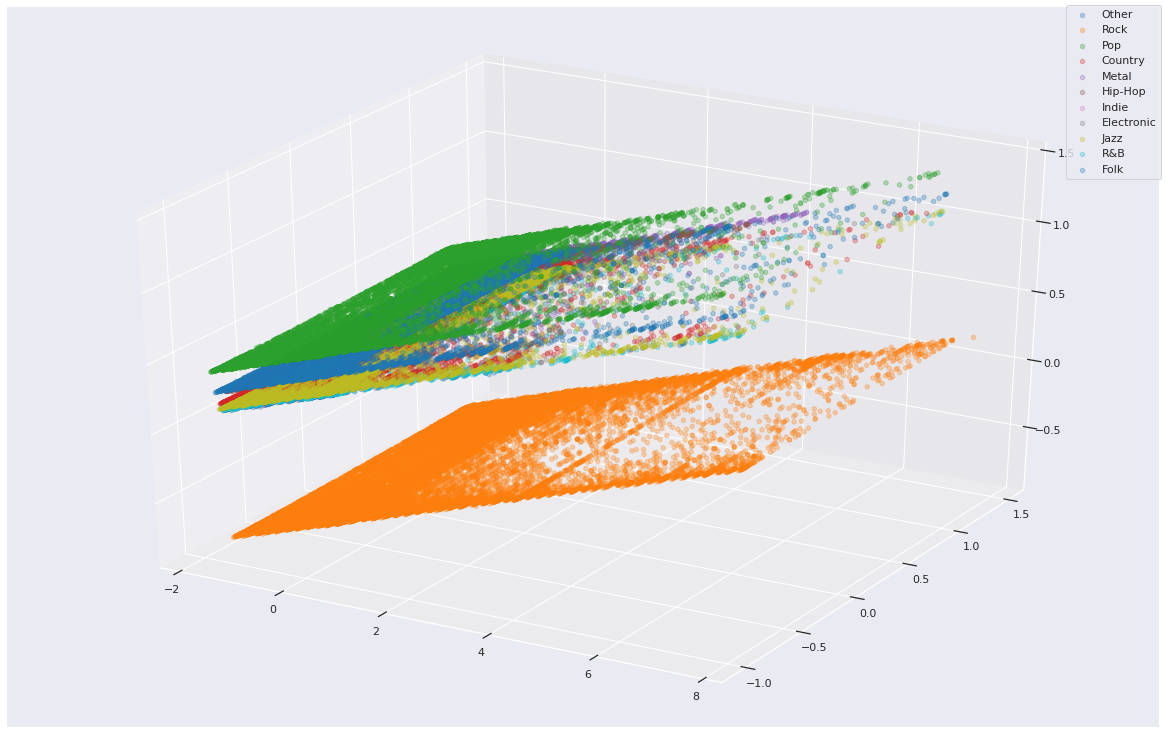

In [0]:
#plotting the 3D graph using all three principal components.
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)
colors = 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:blue'
labels = 'Other','Rock', 'Pop','Country','Metal','Hip-Hop','Indie','Electronic','Jazz','R&B','Folk'

for i, c, label in zip(range(len(labels)), colors, labels):
    ax.scatter(pca_result[pcaData['genreLabel']==i, 0], pca_result[pcaData['genreLabel']==i, 1], pca_result[pcaData['genreLabel']==i, 2], c=c, label=label, alpha=0.3)
fig.legend();

Now, this seems like a far better visualization, and things actually make sense. Notice how each of the genres converge into a 'layer' of their own. There's only 4 layers, but 11 genres - and that's because a lot of the layers are actually merged around the third layer from the top. This implies that these genres mingle a lot with each other, whereas the lowest layer, rock, is completely separate from the rest. Playlists of rock songs will likely stick to rock only.

In [0]:
#code cell to generate a gif of the above graph rotating and save to drive, DO NOT RUN LOCALLY
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)
colors = 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:blue'
labels = 'Other','Rock', 'Pop','Country','Metal','Hip-Hop','Indie','Electronic','Jazz','R&B','Folk'

for i, c, label in zip(range(len(labels)), colors, labels):
    ax.scatter(pca_result[pcaData['genreLabel']==i, 0], pca_result[pcaData['genreLabel']==i, 1], pca_result[pcaData['genreLabel']==i, 2], c=c, label=label, alpha=0.3)
fig.legend();

def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('/gdrive/My Drive/pca_plot.gif', writer=animation.PillowWriter(fps=20))

In [0]:
#we create another dataset for t-SNE and do similar preprocessing.
from sklearn.manifold import TSNE
tsneData = pd.concat([sentiData, OH_cols], axis=1, sort=False)
tsneData.head()

song  year           artist genre  ...    7    8    9   10
0            then-tell-me  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0
1                 honesty  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0
2         you-are-my-rock  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0
3           black-culture  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0
4  all-i-could-do-was-cry  2009  beyonce-knowles   Pop  ...  0.0  1.0  0.0  0.0

[5 rows x 19 columns]

t-SNE is not very efficient and cannot handle more than a few tens of thousands of datapoints before becoming extremely slow. So, we use numpy's permutation to take a random subset of 10% of the total data to run t-SNE on.

In [0]:
#defining the random permutation and setting a seed so results are reproducable.
np.random.seed(42)
rndperm = np.random.permutation(tsneData.shape[0])

In [0]:
#fitting the t-SNE model on 10% of the data.
#preferably do not run again, takes a long time.
tsne_subset = tsneData.loc[rndperm[:int(len(tsneData)//10)],:].copy()
tsne = TSNE(n_components=3, verbose=1, perplexity=10, n_iter=300)
#n_components are once again 3
#verbose = 1 allows us to see the progress of the fitting of the model while we wait
#perplexity is used to optimize performance and results based on the number of features. Values generally range from 5 to 50.
#n_iter is the number of iterations over which it optimizes its probability based approach. Minimum is 250, lower values are faster to compute.
tsne_results = tsne.fit_transform(tsne_subset[(['Sentiment','Sentiment2','yearNorm']+list(range(11)))].values)
tsne_subset['tsne-3d-one'] = tsne_results[:,0]
tsne_subset['tsne-3d-two'] = tsne_results[:,1]
tsne_subset['tsne-3d-three'] = tsne_results[:,2]

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 24075 samples in 0.174s...
[t-SNE] Computed neighbors for 24075 samples in 2.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24075
[t-SNE] Computed conditional probabilities for sample 2000 / 24075
[t-SNE] Computed conditional probabilities for sample 3000 / 24075
[t-SNE] Computed conditional probabilities for sample 4000 / 24075
[t-SNE] Computed conditional probabilities for sample 5000 / 24075
[t-SNE] Computed conditional probabilities for sample 6000 / 24075
[t-SNE] Computed conditional probabilities for sample 7000 / 24075
[t-SNE] Computed conditional probabilities for sample 8000 / 24075
[t-SNE] Computed conditional probabilities for sample 9000 / 24075
[t-SNE] Computed conditional probabilities for sample 10000 / 24075
[t-SNE] Computed conditional probabilities for sample 11000 / 24075
[t-SNE] Computed conditional probabilities for sample 12000 / 24075
[t-SNE] Computed conditional probabilities for sam

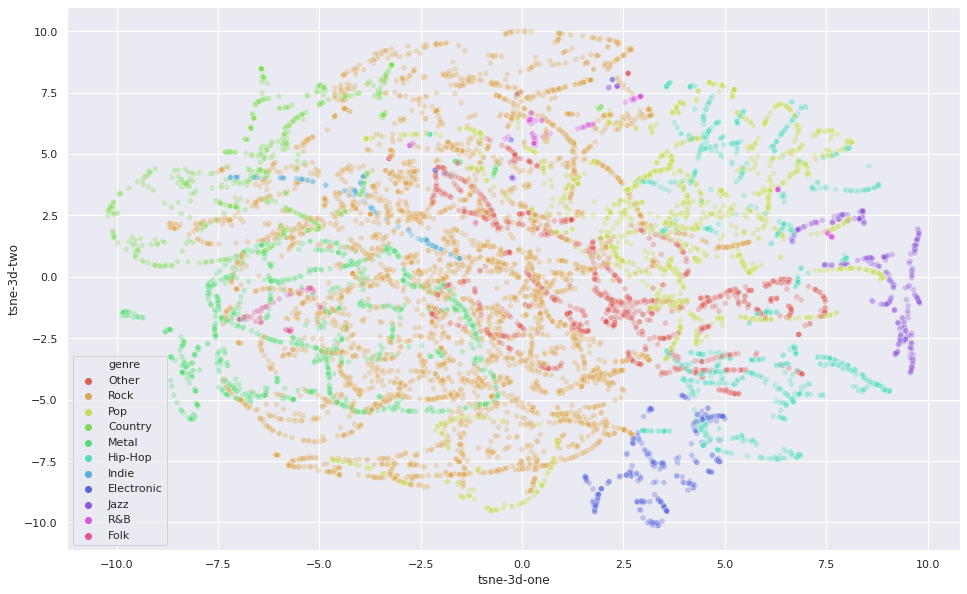

In [0]:
#plotting the 2D figure
plt.figure(figsize=(16,10))
sb.scatterplot(
    x="tsne-3d-one", y="tsne-3d-two",
    hue="genre",
    palette=sb.color_palette("hls", 11),
    data=tsne_subset,
    legend="full",
    alpha=0.3
)

Much like the PCA figure, the 2D figure of t-SNE is messy and there's not much we can infer from it. However, unlike PCA, you can actually start to see the genres form clusters, however messy they may be.

Now, let's plot the graph in 3D using all three dimensions.

In [0]:
#similar preprocessing as with PCA
labelEnc = {'Other':0,'Rock':1, 'Pop':2,'Country':3,'Metal':4,'Hip-Hop':5,'Indie':6,'Electronic':7,'Jazz':8,'R&B':9,'Folk':10}
genreLabel = tsne_subset.genre.apply(lambda x: labelEnc[x])
tsne_subset['genreLabel'] = genreLabel

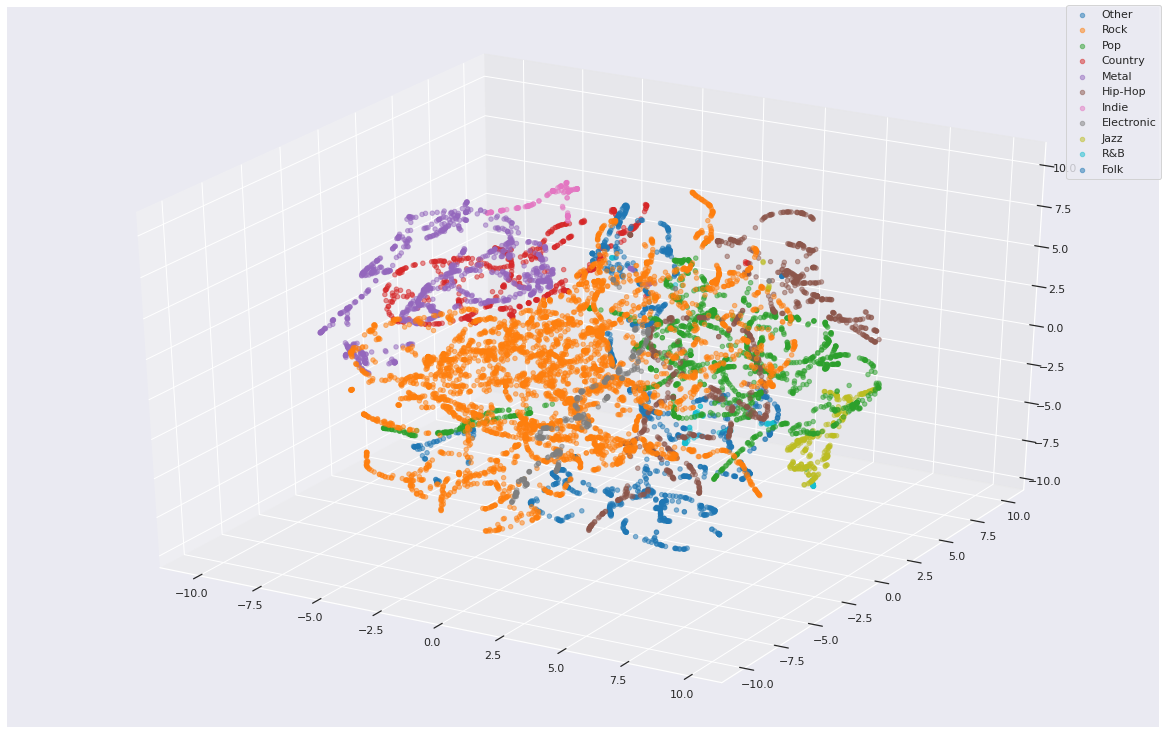

In [0]:
#plotting the 3D graph
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)
colors = 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:blue'
labels = 'Other','Rock', 'Pop','Country','Metal','Hip-Hop','Indie','Electronic','Jazz','R&B','Folk'

for i, c, label in zip(range(len(labels)), colors, labels):
    ax.scatter(tsne_results[tsne_subset['genreLabel']==i, 0], tsne_results[tsne_subset['genreLabel']==i, 1], tsne_results[tsne_subset['genreLabel']==i, 2], c=c, label=label, alpha=0.5)
fig.legend();

The above figures lets us clearly see the genres clustering. At the same time. there are several songs that mingle between multiple clusters and these are likely great for transitioning from one genre to another in a playlist. Due to t-SNE's probability based approach, the notion of distance in the above graph has no real meaning, but it allows us to see clear patterns in the data.

If running this on colab with Drive, try running the code cell below to get a rotating gif of the graph for better understanding.

In [0]:
#code cell to generate a gif of the above graph rotating and save to drive, DO NOT RUN LOCALLY
from matplotlib import animation
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)
colors = 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:blue'
labels = 'Other','Rock', 'Pop','Country','Metal','Hip-Hop','Indie','Electronic','Jazz','R&B','Folk'

for i, c, label in zip(range(len(labels)), colors, labels):
    ax.scatter(tsne_results[tsne_subset['genreLabel']==i, 0], tsne_results[tsne_subset['genreLabel']==i, 1], tsne_results[tsne_subset['genreLabel']==i, 2], c=c, label=label, alpha=0.5)
fig.legend();

def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('/gdrive/My Drive/tsne_plot.gif', writer=animation.PillowWriter(fps=20))

## **Conclusion and References**



##### **Conclusion**





*   With our final model, we believe we met our initial objective.
*   As shown by the visualizations of our model, the genres seem to form clusters, but also mingle with each other quite a bit.
*   An interesting result of our functions is that lesser known artists are recommended nearly as much as popular ones, so it's a great way to find new artists you might like listening to.
*   The model could definitely be improved upon by taking song popularity, artist popularity, user preferences and user-user similarity into account, which could be possible to implement by building upon this model with more datasets.
*   Another possible addition could be the data of the song itself, as songs are not simply about the lyrics but the music as well. Details about a song's tempo, style, beat, etc could be used to improve the model as well.
*   While the quality of our recommendations cannot be objectively measured, we "beta tested" the model on Instagram and recieved a lot of positive comments on the recommendations provided by our system, so we're happy with what we managed to achieve.



##### **References**






For documentation and syntaxes


1.   https://pandas.pydata.org/
2.   https://numpy.org/
3.   https://seaborn.pydata.org/
4.   https://scikit-learn.org/
5.   https://matplotlib.org/
6.   https://stackoverflow.com/
7.   https://www.nltk.org/
8.   https://docs.python.org/3/library/tkinter.html


References used for ideas on model building


1.   https://kvsingh.github.io/lyrics-sentiment-analysis.html
2.   https://planspace.org/20150607-textblob_sentiment/
3.   https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
4.   https://lvdmaaten.github.io/tsne/
5.   http://blog.mahler83.net/2019/10/rotating-3d-t-sne-animated-gif-scatterplot-with-matplotlib/
6.   https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
7.   https://towardsdatascience.com/sentiment-analysis-of-all-billboard-hot-100-songs-over-time-1958-2019-3329439e7c1a




